<a href="https://colab.research.google.com/github/hjones234/INTRO-TO-AI-GROUP-20-PROJECT/blob/main/morespare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Section 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image
import pandas as pd
import os

In [ ]:
# Section 1: Image import
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation
!unzip augmented-forest-segmentation

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

In [ ]:
# Section 2: Dataset Prep
manual_seed = 42
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)
random_state = 42
class Image_seg_data(Dataset):
  #note the random_state bit plants a seed (just tried to readd that but)
  #just added he random state bit back in
    def __init__(self, csv_file, pathsat, pathmasks, transform=None ,train=True, test_size=0.2, random_state=random_state):
        self.data_frame = pd.read_csv(csv_file)
        self.path = pathsat
        self.pathmask = pathmasks
        self.transform = transform


         # Split the data into training and testing sets
        train_data, test_data = train_test_split(self.data_frame, test_size=test_size , random_state=random_state)

        # Use either training or testing data based on the 'train' parameter
        if train:
            self.data = train_data
        else:
            self.data = test_data

    def __len__(self):
        return len(self.data_frame)
    def __getitem__(self, index):
        img_name = os.path.join(self.path, self.data_frame.iloc[index, 0])

    # Need this or we get an error about the files not existing
        if not img_name.endswith('.jpg'):
            img_name += '.jpg'

        stat_image = Image.open(img_name).convert("RGB")

    # Load the mask as a single-channel image (grayscale)
        mask_name = os.path.join(self.pathmask, self.data_frame.iloc[index, 1])
        if not mask_name.endswith('.jpg'):
            mask_name += '.jpg'

        #mask_image = Image.open(mask_name).convert("L")  # Convert to grayscale

        #A potential fix
        mask_image = Image.open(mask_name).convert("L")  # Convert to grayscale

    # Ensure binary mask
        mask_np = (np.array(mask_image) > 0).astype(np.uint8)
        mask_image = Image.fromarray(mask_np)

        if self.transform:
          stat_image = self.transform(stat_image)
          mask_image = self.transform(mask_image)

    # Convert mask_image to single-channel if it has more than one channel
        mask_image = mask_image[0, :, :].unsqueeze(0)

        return stat_image, mask_image

In [ ]:
# Section 4: Transformations and Creating train and test data sets
transform2 = transforms.Compose([

    transforms.Resize((256, 256)),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
])


csv_file_path2 = '/content/meta_data.csv'
path_directory2 = '/content/Forest Segmented/Forest Segmented/images'
path_masks = '/content/Forest Segmented/Forest Segmented/masks'

# Instantiate the dataset with the correct transformations splitting into train and test datsets
#just trying to add the random state bit in
train_dataset2 = Image_seg_data(csv_file=csv_file_path2, pathsat=path_directory2, pathmasks = path_masks , transform= transform2, train=True, random_state=random_state)
test_dataset2 = Image_seg_data(csv_file=csv_file_path2, pathsat=path_directory2 , pathmasks = path_masks, transform= transform2, train=False, random_state = random_state)

# DataLoader instantiation
#note to self jnust changed the train one to shuffle = Fakse
batch_size = 16
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=False)

test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)

In [ ]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Define the encoder (contracting path)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the decoder (expansive path)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        # Define the dropout layer
        self.dropout = nn.Dropout2d(p=0.5)

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # print("x1 size:", x1.size())  # Print size of x1

        # Upsample x1 to match the size of x2
        x1_upsampled = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=True)
        # print("x1_upsampled size:", x1_upsampled.size())  # Print size of x1_upsampled

        # Adjust the size of x1 to match x1_upsampled
        x1_adjusted = self.center_crop(x1, x1_upsampled.shape[2:])
        # print("x1_adjusted size:", x1_adjusted.size())  # Print size of x1_adjusted

        # Resize x1_adjusted to match the spatial dimensions of x1_upsampled
        x1_adjusted_resized = F.interpolate(x1_adjusted, size=x1_upsampled.shape[2:], mode='bilinear', align_corners=True)
        # print("x1_adjusted_resized size:", x1_adjusted_resized.size())  # Print size of x1_adjusted_resized

        # Decoder
        x2 = self.decoder(torch.cat([x1_adjusted_resized, x1_upsampled], dim=1))
        # print("x2 size:", x2.size())  # Print size of x2

        # Apply dropout
        x2 = self.dropout(x2)

        return x2

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

# Set the number of input and output channels based on your data
in_channels = 3  # Assuming RGB images
out_channels = 1  # Output is a binary mask, adjust if needed

# Create an instance of the U-Net model
mas_model = UNet(in_channels, out_channels)


In [ ]:
#From the paper using their options paper says (0.001)
optimizer = optim.Adam(mas_model.parameters(), lr=0.001)
criterion2 = nn.BCELoss()



#A way to maybe help the loss
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch 1/10, Loss: 0.6931496233144774
Epoch 2/10, Loss: 0.6931487218700728
Epoch 3/10, Loss: 0.6931507343786624
Epoch 4/10, Loss: 0.6931496387174004
Epoch 5/10, Loss: 0.6931488060260436
Epoch 6/10, Loss: 0.6931491947398115
Epoch 7/10, Loss: 0.6931504235663447
Epoch 8/10, Loss: 0.6931493790614577
Epoch 9/10, Loss: 0.6931483871598867
Epoch 10/10, Loss: 0.6931497371560816


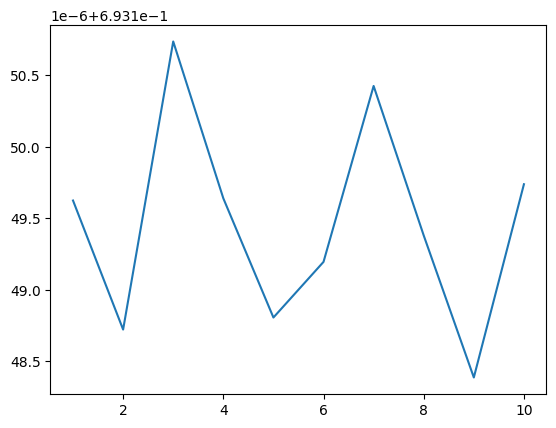

In [ ]:
# #Galit's tryb
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mas_model.to(device)
num_epochs = 10

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_values = []
for epoch in range(num_epochs):
    mas_model.train()
    running_loss = 0

    for inputs, targets in train_loader2:
        optimizer.zero_grad()

        # Move input tensors to the same device as the model
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = mas_model(inputs)

        # Assuming your original target tensor has 3 channels, convert it to a single-channel binary mask
        targets = targets[:, 0, :, :].unsqueeze(1)  # Assuming the first channel represents the mask

        # Convert the output to a single-channel binary mask

        # Ensure that targets require gradients
        #targets.requires_grad = True
        outputs = torch.sigmoid(outputs)
        loss = criterion2(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
    scheduler.step()
    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader2.dataset)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

x = [i for i in range(1,11)]
plt.plot(x,loss_values)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
def compute_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Threshold outputs at 0.5 to get binary predictions

            # Convert targets to binary format if needed
            # targets = (targets > 0.5).float()

            total += targets.size(0)  # Increment the total number of samples
            correct += (predicted == targets).sum().item()  # Increment the correct predictions

    accuracy = correct / total
    return accuracy

compute_accuracy(mas_model, test_loader2)


25005.742364917776